# Genentech Cervical Cancer Screening - Insights

https://www.kaggle.com/c/cervical-cancer-screening/

Cervical cancer is the third most common cancer in women worldwide, affecting over 500,000 women and resulting in approximately 275,000 deaths every year. Most women in the US have access to cervical cancer screening, yet 4,000 women die every year from cervical cancer in the US and it is estimated that 30% of US women do not receive regular pap screenings. 

Prior research suggests that lower screening rates are associated with low income, low education, lack of interaction with the healthcare system, and lack of health insurance. But research also shows that even in women with access to healthcare fail to get this preventive test, indicating that barriers like lack of education and not being comfortable with the procedure are influencing their behavior.

If one could better identify women who are not being screened, education campaigns could target them with content that speaks directly to their unique risk factors. Identifying predictors of not receiving pap smears will provide important information to stakeholders in cervical cancer prevention who run awareness programs.

Below is one analysis for the [Kaggle Genentech Cervical Cancer Screening](https://www.kaggle.com/c/cervical-cancer-screening/) competition.  

### The focus is on identifying healthy women who are not being screened.

- By Paul Perry, Elena Cuoco, and Zygmunt Zając.

## Load 

This notebook is almost runnable in Kaggle scripts, but some features extractions would take too long, and we make use of geopandas for mapping functions.  We use Postgres, but it would be easily swappable for Kaggle's sqlite3.

In [1]:
# imports
import sys # for stderr
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# settings 
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (10.0, 10.0)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', 50)

In [3]:
# versions 
import sys
print(pd.datetime.now())
print('Python: '+sys.version)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+skl.__version__)

2016-02-08 13:43:29.988998
Python: 2.7.11 |Anaconda 2.4.0 (x86_64)| (default, Dec  6 2015, 18:57:58) 
[GCC 4.2.1 (Apple Inc. build 5577)]
numpy: 1.10.2
pandas: 0.17.1
sklearn: 0.17


In [4]:
import psycopg2
# import sqlite3

In [5]:
db = psycopg2.connect("dbname='ccancer' user='paulperry' host='localhost' password=''")
#db = sqlite3.connect('../input/database.sqlite')

In [6]:
import datetime
start = datetime.datetime.now()
print(start)

2016-02-08 13:43:33.322108


In [7]:
fdir = './features/'

In [8]:
train_file = './input/patients_train.csv.gz'
train = pd.read_csv(train_file)
train.set_index('patient_id', inplace=True)
train.drop('patient_gender', axis = 1, inplace = True )
train_exclude = pd.read_csv('./input/train_patients_to_exclude.csv', header=None, names=['patient_id'])
train.drop(train_exclude.patient_id, inplace=True)
original_train_rows = train.shape[0]
print(train.shape)

(1157817, 6)


In [9]:
train[:5]

,patient_age_group,patient_state,ethinicity,household_income,education_level,is_screener
patient_id,,,,,,
336201912,51-53,SD,ALL OTHER,UNKNOWN,UNKNOWN,1
94237712,39-41,NE,ALL OTHER,UNKNOWN,UNKNOWN,1
186124512,24-26,CA,ALL OTHER,UNKNOWN,UNKNOWN,0
767144212,27-29,NY,ALL OTHER,UNKNOWN,UNKNOWN,1
104743512,30-32,HI,ALL OTHER,UNKNOWN,UNKNOWN,0


In [10]:
test_file = './input/patients_test.csv.gz'
test = pd.read_csv(test_file)
test.set_index('patient_id', inplace=True)
test.drop( 'patient_gender', axis = 1, inplace = True )
test_exclude = pd.read_csv('./input/test_patients_to_exclude.csv', header=None, names=['patient_id'])
test.drop(test_exclude.patient_id, inplace=True)
original_test_rows = test.shape[0]
print(test.shape)

(1701813, 5)


In [11]:
test[:5]

,patient_age_group,patient_state,ethinicity,household_income,education_level
patient_id,,,,,
148341312,66-68,TX,ALL OTHER,UNKNOWN,UNKNOWN
130010912,45-47,IN,ALL OTHER,UNKNOWN,UNKNOWN
103994412,27-29,CA,ALL OTHER,UNKNOWN,UNKNOWN
318658812,27-29,TN,ALL OTHER,UNKNOWN,UNKNOWN
93750312,54-56,AZ,ALL OTHER,UNKNOWN,UNKNOWN


## Overall screening percentage

The average screening of patients overall is 55%:

In [12]:
train.is_screener.mean()

0.5577850385682711

## Screening by Age, Ethnicity, Household income, and Education level

At high level, younger patients have a higher likelihood of being screened, and while a higher household income has a higher likelihood of being screened, ethnicity and education level are not distinguishing features at the overall aggregate level.

In [27]:
age = pd.DataFrame([train.groupby('patient_age_group').is_screener.count(),
                    train.groupby('patient_age_group').is_screener.mean()])
age = age.T
age.columns = ['count','screened']
age

,count,screened
patient_age_group,,
24-26,71355,0.718884
27-29,72822,0.704663
30-32,70283,0.678044
33-35,66622,0.656510
36-38,67729,0.641572
39-41,74664,0.624558
42-44,72312,0.602500
45-47,81554,0.581247
48-50,86363,0.558978


In [178]:
# train.groupby('ethinicity').is_screener.count()
train.groupby('ethinicity').is_screener.mean()

ethinicity
AFRICAN AMERICAN    0.550724
ALL OTHER           0.563541
CAUCASIAN           0.552519
HISPANIC            0.588702
Name: is_screener, dtype: float64

In [176]:
#train.groupby('household_income').is_screener.count()
train.groupby('household_income').is_screener.mean()

household_income
$100K+      0.600612
<$50-99K    0.563834
<=$49K      0.517505
UNKNOWN     0.565792
Name: is_screener, dtype: float64

In [177]:
#train.groupby('education_level').is_screener.count()
train.groupby('education_level').is_screener.mean()

education_level
ASSOCIATE DEGREE AND ABOVE    0.592762
HIGH SCHOOL OR LESS           0.542836
SOME COLLEGE                  0.552917
UNKNOWN                       0.559441
Name: is_screener, dtype: float64

## Interaction with the Medical System: Have had a Medical Exam
As a measure of the patient's interaction with the medical system, we distinguish whether the patient has ever had medical exam ( diagnosis_code in ('V70', 'V70.0', 'V70.1', 'V70.2', 'V70.3', 'V70.4', 'V70.5', 'V70.6', 'V70.7', 'V70.8', 'V70.9'), and calculate the likelihood of screening for the patient.

In [145]:
medical_exam = pd.read_sql_query("select * from diagnosis where diagnosis_code in \
    ('V70', 'V70.0', 'V70.1', 'V70.2', 'V70.3', 'V70.4', 'V70.5', 'V70.6', 'V70.7', 'V70.8', 'V70.9' ) \
    and patient_id in (select patient_id from patients_train );", db)

In [146]:
medical_exam = pd.read_csv('./features/train_medical_exam.csv')

There are 1157817 patients in the train set, of which, 498157 have had a medical exam during the entire 7 years of the data.  

In [147]:
medical_exam.drop_duplicates('patient_id', inplace=True)
medical_exam.shape[0]

498157

So less than half of the population has had a regular medical exam:

In [148]:
medical_exam.shape[0] / float(train.shape[0])

0.43025538578203637

But the average is 66% for patients who have had any medical exam:

In [149]:
train.loc[medical_exam.patient_id].is_screener.mean()

0.668441876757729

And only 47% if they never have had one:

In [150]:
train.loc[~train.index.isin(medical_exam.patient_id)].is_screener.mean()

0.4742200527544493

## Patient was referred to a Gynecological Exam

If the patient had one of these codes, then they may have been referred to a gynecological exam:
```
 diagnosis_code |  diagnosis_description                                                 
----------------+-----------------------------------
 V72.3          | GYNECOLOGICAL EXAMINATION
 V72.31         | ROUTINE GYNECOLOGICAL EXAMINATION
```

In [39]:
gyn_exam = pd.read_sql_query("select t1.patient_id, claim_type, diagnosis_date, diagnosis_code from diagnosis t1 \
                             right join patients_train t2 on (t1.patient_id=t2.patient_id ) \
                             where diagnosis_code in ('V72.3', 'V72.31');", db)

In [40]:
gyn_exam[:5]

,patient_id,claim_type,diagnosis_date,diagnosis_code
0,112956268,MX,201310,V72.31
1,183576058,MX,201310,V72.31
2,187476589,MX,201310,V72.31
3,163205483,MX,201310,V72.31
4,170954263,MX,201310,V72.31


In [41]:
gyn_exam.drop_duplicates('patient_id', inplace=True)
gyn_exam.shape[0]

648737

More than have the patients in this database have had a gynecological exam:

In [43]:
gyn_exam.shape[0] / float(train.shape[0])

0.5603104808445549

And if they have had an exam then the likelihood that they have been screened is high:

In [44]:
train.loc[gyn_exam.patient_id].is_screener.mean()

0.8079591575630802

And quite low if they have not had a gynecological exam:

In [50]:
no_gyn_exam = train.loc[~train.index.isin(gyn_exam.patient_id)]
no_gyn_exam.is_screener.mean()

0.23898012100259292

We can look at whether a patient has had a medical exam and a gynecological exam

In [187]:
medical_and_gyn_exam_df = train.loc[medical_exam.loc[medical_exam.patient_id.isin(gyn_exam.patient_id)].patient_id]
medical_and_gyn_exam = medical_and_gyn_exam_df.is_screener.mean()

In [180]:
medical_and_no_gyn_exam_ids = set(medical_exam.patient_id) - set(gyn_exam.patient_id) 
medical_and_no_gyn_exam = train.loc[medical_and_no_gyn_exam_ids].is_screener.mean()

In [182]:
no_medical_and_gyn_exam_ids = set(gyn_exam.patient_id) - set(medical_exam.patient_id)
no_medical_and_gyn_exam = train.loc[no_medical_and_gyn_exam_ids].is_screener.mean()

In [181]:
no_medical_and_no_gyn_exam_ids = set(train.index) - (set(medical_exam.patient_id) | set(gyn_exam.patient_id))
no_medical_and_no_gyn_exam = train.loc[no_medical_and_no_gyn_exam_ids].is_screener.mean()

In [189]:
mat = [[medical_and_gyn_exam, medical_and_no_gyn_exam], [no_medical_and_gyn_exam, no_medical_and_no_gyn_exam]]

In [141]:
# Pick a colormap
# I'd like to set alpha=0.2 , but haven't figured it out yet
cmap='RdYlGn'

In [194]:
mat_df = pd.DataFrame(mat, index=['Medical Exam', 'No Medical Exam'], columns=['Gyn Exam', 'No Gyn Exam'])
mat_df

,Gyn Exam,No Gyn Exam
Medical Exam,0.831919,0.336702
No Medical Exam,0.782578,0.192350


Looking at the each of the demographics separately, at the aggregate level, for the patients that 
did not have a medical exam or a gynecological exam, we don't see any trends other than younger patients are more likely to be screened:

In [192]:
df = train.loc[no_medical_and_no_gyn_exam_ids].groupby(['patient_age_group',
                                                        'household_income']).is_screener.mean().unstack()
df.style.background_gradient(cmap, axis=0, low=.5, high=1)

In [196]:
df = train.loc[no_medical_and_no_gyn_exam_ids].groupby(['patient_age_group',
                                                        'ethinicity']).is_screener.mean().unstack()
df.style.background_gradient(cmap, axis=0, low=.5, high=1)

In [197]:
df = train.loc[no_medical_and_no_gyn_exam_ids].groupby(['patient_age_group',
                                                        'education_level']).is_screener.mean().unstack()
df.style.background_gradient(cmap, axis=0,  low=.5, high=1)

## Patient was pregnant or related

Our models showed the following diagnosis were strong predictors of being screened:
- 646.83 	OTHER SPECIFIED ANTEPARTUM COMPLICATIONS		
- 648.93 	OTHER CURRENT CONDITIONS CLASSIFIABLE ELSEWHERE OF MOTHER, ANTEPARTUM		
- 650	    NORMAL DELIVERY		
- V22.0 	SUPERVISION OF NORMAL FIRST PREGNANCY
- V22.1 	SUPERVISION OF OTHER NORMAL PREGNANCY
- V22.2 	PREGNANT STATE, INCIDENTAL
- V24.2 	ROUTINE POSTPARTUM FOLLOW-UP
- V25.2 	STERILIZATION
- V27.0 	MOTHER WITH SINGLE LIVEBORN
- V28.3 	ENCOUNTER FOR ROUTINE SCREENING FOR MALFORMATION USING ULTRASONICS
- V74.5 	SCREENING EXAMINATION FOR VENEREAL DISEASE

In [94]:
pregnancy = pd.read_sql_query("select t1.patient_id, claim_type, diagnosis_date, diagnosis_code from diagnosis t1 \
                             right join patients_train t2 on (t1.patient_id=t2.patient_id) where diagnosis_code in \
                             ('V22.0','V22.1','V22.2','V24.2','V25.2','V27.0','V28.3','V70.0','V74.5');", db)
pregnancy.shape

(3905637, 4)

In [95]:
pregnancy.to_csv('train_pregnant.csv', index=False)

In [96]:
pregnancy.drop_duplicates('patient_id', inplace=True)
pregnancy.shape

(627113, 4)

Patients that had one of the above diagnosis were screened with the following likelihood:

In [97]:
train.loc[pregnancy.patient_id].is_screener.mean()

0.6839947505473495

And those that were not:

In [98]:
train.loc[~train.index.isin(pregnancy.patient_id)].is_screener.mean()

0.40864775844915435

Looking at these pregnancy diagnosis by demographics:

In [198]:
df = train.loc[pregnancy.patient_id].groupby(['patient_age_group',
                                              'household_income']).is_screener.mean().unstack()
df.style.background_gradient(cmap, axis=0, low=.5, high=1)

Versus the patients who has no such diagnosis:

In [199]:
df = train.loc[~train.index.isin(pregnancy.patient_id)].groupby(['patient_age_group',
                                              'household_income']).is_screener.mean().unstack()
df.style.background_gradient(cmap, axis=0,  low=.5, high=1)

Again, by ethnicity, for patients that had such diagnosis:

In [200]:
df = train.loc[pregnancy.patient_id].groupby(['patient_age_group',
                                              'ethinicity']).is_screener.mean().unstack()
df.style.background_gradient(cmap, axis=0,  low=.5, high=1)

And those patients that had no such diagnosis:

In [201]:
df = train.loc[~train.index.isin(pregnancy.patient_id)].groupby(['patient_age_group',
                                              'ethinicity']).is_screener.mean().unstack()
df.style.background_gradient(cmap, axis=0,  low=.5, high=1)

## Patient has other highly predictive diagnosis

Our modelling revealed the following diagnosis were also highly predictive of screening, and the same analysis as above could be performed, but these diagnosis look like the patient is already down a path that required that they be screened, but we are looking for patients that are not being screened.

- 462	ACUTE PHARYNGITIS		
- 496	CHRONIC AIRWAY OBSTRUCTION, NOT ELSEWHERE CLASSIFIED		
- 585.3	CHRONIC KIDNEY DISEASE, STAGE III (MODERATE)		
- 616	CERVICITIS AND ENDOCERVICITIS		
- 616.1	VAGINITIS AND VULVOVAGINITIS, UNSPECIFIED		
- 620.2	OTHER AND UNSPECIFIED OVARIAN CYST		
- 622.1	DYSPLASIA OF CERVIX, UNSPECIFIED		
- 622.11	MILD DYSPLASIA OF CERVIX		
- 623.5	LEUKORRHEA, NOT SPECIFIED AS INFECTIVE		
- 625.3	DYSMENORRHEA		
- 625.9	UNSPECIFIED SYMPTOM ASSOCIATED WITH FEMALE GENITAL ORGANS		
- 626	ABSENCE OF MENSTRUATION		
- 626.2	EXCESSIVE OR FREQUENT MENSTRUATION		
- 626.4	IRREGULAR MENSTRUAL CYCLE		
- 626.8	OTHER DISORDERS OF MENSTRUATION AND OTHER ABNORMAL BLEEDING FROM FEMALE GENITAL				
- 795	ABNORMAL GLANDULAR PAPANICOLAOU SMEAR OF CERVIX		

## Patient had procedures predictive of not being screened

We performed a L1 (Lasso) feature selection using Vowpal Wabbit on procedures and found the following 
procedures positively correlated with a patient being screened:

```
procedure_code   procedure_description                            RelScore
57454            COLPOSCOPY CERVIX BX CERVIX & ENDOCRV CURRETAGE   100.00%
1252             GJB2 GENE ANALYSIS FULL GENE SEQUENCE              96.93%
57456            COLPOSCOPY CERVIX ENDOCERVICAL CURETTAGE           95.00%
57455            COLPOSCOPY CERVIX UPPR/ADJCNT VAGINA W/CERVIX BX   91.42%
S4020            IN VITRO FERTILIZATION PROCEDURE CANCELLED BEFOR   85.76%
S0605            DIGITAL RECTAL EXAMINATION, MALE, ANNUAL           83.64%
G0143            SCREENING CYTOPATHOLOGY, CERVICAL OR VAGINAL (AN   78.39%
90696            DTAP-IPV VACCINE CHILD 4-6 YRS FOR IM USE          76.98%
S4023            DONOR EGG CYCLE, INCOMPLETE, CASE RATE             76.67%
69710            IMPLTJ/RPLCMT EMGNT BONE CNDJ DEV TEMPORAL BONE    72.06%
```

and the following procedures negatively correlated:

```
procedure_code        procedure_description             RelScore
K0735  SKIN PROTECTION WHEELCHAIR SEAT CUSHION, ADJUSTA  -62.48%
34805  EVASC RPR AAA AORTO-UNIILIAC/AORTO-UNIFEM PROSTH  -64.68%
L5975  ALL LOWER EXTREMITY PROSTHESIS, COMBINATION SING  -65.39%
89321  SEMEN ANALYSIS SPERM PRESENCE&/MOTILITY SPRM      -65.51%
S9145  INSULIN PUMP INITIATION, INSTRUCTION IN INITIAL   -69.96%
00632  ANESTHESIA LUMBAR REGION LUMBAR SYMPATHECTOMY     -77.13%
27756  PRQ SKELETAL FIXATION TIBIAL SHAFT FRACTURE       -78.61%
3303F  AJCC CANCER STAGE IA, DOCUMENTED (ONC), (ML)      -82.77%
23675  CLTX SHOULDER DISLC W/SURG/ANTMCL NECK FX W/MANJ  -83.14%
Q4111  GAMMAGRAFT, PER SQUARE CENTIMETER                 -85.49%
```

It seems clear that a number of negatively correlated procedures identify patients that have bigger problems than the need for a cervical exam, and it is possible physicians have not recommended a screening for these reasons.  Therefore the analysis above should be rerun without these patients skewing the likelihood percentages.

## Where are the patients ?

We can review all slices of screener likleihoods by geography.

In [153]:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from matplotlib.collections import PatchCollection
import geopandas as gpd
print('geopandas: '+gpd.__version__)

geopandas: 0.1.0.dev-


In [168]:
# settings  
plt.rcParams['figure.figsize']=(16,14) 

In [154]:
# US Bounding box
minx, miny, maxx, maxy = -125,22,-65,50  # USA bounding box
usbbox = Polygon([(minx,miny),(minx,maxy),(maxx, maxy),(maxx,miny)])

## Map States

Looking at the likelyhood by state:

In [155]:
# We grabbed the USA shape files from : https://github.com/matplotlib/basemap/tree/master/examples
# or state files from here: https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html
# We took the CBSA files from https://www.census.gov/geo/maps-data/data/cbf/cbf_msa.html

In [157]:
state_pct = pd.read_csv('./features/state_screen_percent.csv')
state_pct.set_index('patient_state', inplace=True)
state_pct[:5]

,state_pct
patient_state,
AK,0.496903
AL,0.417596
AR,0.437814
AZ,0.504682
CA,0.526563


In [162]:
states_key = pd.read_csv('./datastudy/state.csv')
states_key.set_index('name_long', inplace=True)
states_key[:5]

,name_short
name_long,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


In [163]:
state_file = './datastudy/st99_d00.shp'
#bbox=(-119,22,64,49)
bbox=(-125,22,-65,50)
kw = dict(bbox=bbox)
states_map = gpd.GeoDataFrame.from_file(state_file, **kw)

#state_file = 'cb_2014_us_state_500k.shp'
# states = gpd.GeoDataFrame.from_file(state_file)

if gpd.__version__ != '0.1.0.dev-':  # temp fix 
    states_map.geometry = convert_3D_2D(states.geometry)

In [164]:
states_map = states_map.merge(states_key, left_on='NAME', right_index=True, how='left')
states_map = states_map.merge(state_pct, left_on='name_short', right_index=True, how='left')

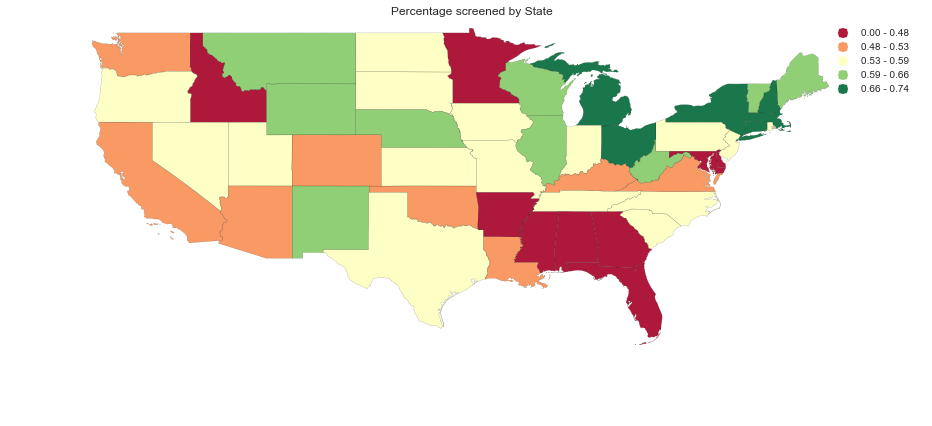

In [169]:
states_map = states_map[states_map.geometry.within(usbbox)]
# plt.figure(figsize=(12,10))
ax = states_map[states_map.state_pct.notnull()].plot(column='state_pct', scheme='QUANTILES', k=5, colormap='RdYlGn', 
                                             alpha=0.9, linewidth=0.1, legend=True)
ax.axis('off')
plt.title('Percentage screened by State')
plt.show()

## By CBSA

Every patient was mapped to the [CBSA](https://en.wikipedia.org/wiki/Core-based_statistical_area) where they had the most diagnosis.  We can then look at the likelihoods by these areas.  Combining this map as screened by the features above would render a better map for targeting patients who are not being screened.

In [171]:
cbsa_pct = pd.read_csv('./features/cbsa_pct.csv.gz')
cbsa_pct.set_index('cbsa', inplace=True)
cbsa_pct[:5]

,pct_screened
cbsa,
10100,0.528302
10140,0.312376
10180,0.301802
10220,0.591623
10300,0.681319


In [172]:
cbsa = gpd.GeoDataFrame.from_file('./datastudy/cb_2014_us_cbsa_500k.shp')
cbsa.GEOID = cbsa.GEOID.astype(float)
cbsa.set_index('GEOID', inplace=True)
cbsa.shape

(929, 8)

In [173]:
cbsa['pct_screened'] = cbsa_pct.pct_screened

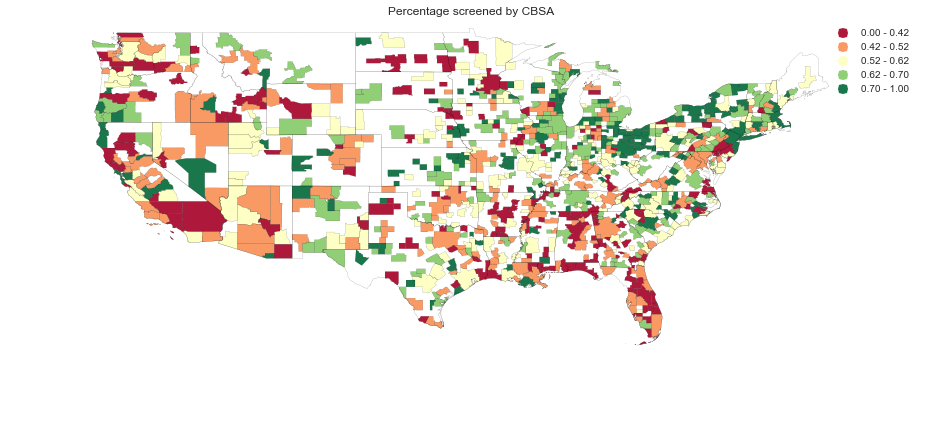

In [175]:
cbsa = cbsa[cbsa.geometry.within(usbbox)]
ax = states_map.plot(column=None, color='white', linewidth=0.1)
ax = cbsa[cbsa.pct_screened.notnull()].plot(column='pct_screened', scheme='QUANTILES', k=5, colormap='RdYlGn', 
               alpha=0.9, ax=ax, linewidth=0.1, legend=True)
ax.axis('off')
plt.title('Percentage screened by CBSA')
plt.show()

## Further Work

- There are many physicians performing a routine gynecological exam that have a `specialty_code` other than `OBG` or `GYN`.  Looking into these differences by geography might be interesting.
- We have started to look at the percentage of screening by the `primary_practitioner` referring or performing the GYN exam and there are some stark differences.  Understanding these differences will help target the physicians rather than the patients.